# 02-02 : Multi-label text classification

This notebook form part of a bigger project that aims to first classify unlabeled data using a LLM (Large Language Model), then from this data train efficient smaller models that can be used in production at lower costs than using a LLM.

https://github.com/JohnnyFoulds/multi-intent-classification/tree/feature/mutilclass_model


After extracting intents, we use Keras, a comprehensive deep learning library, to develop a multi-class classification model.

## Table of Contents


## References

The following is a list of technical references that were consulted during the development of this notebook. Where specific papers or books were used, they are cited directly in the text.

- [Large-scale multi-label text classification](https://keras.io/examples/nlp/multi_label_classification/)
- [A Smooth F1 Score Surrogate Loss for Multilabel Classification](https://arxiv.org/abs/2108.10566)
- [Bidirectional LSTM on IMDB](https://keras.io/examples/nlp/bidirectional_lstm_imdb/)
- [Perform text classification with KerasNLP](https://www.youtube.com/watch?v=Wb8-1O8bW68)
- [Getting Started with KerasNLP](https://keras.io/guides/keras_nlp/getting_started/)
- [Getting Started with KerasNLP (Notebook)](https://colab.research.google.com/github/keras-team/keras-io/blob/master/guides/ipynb/keras_nlp/getting_started.ipynb)
- [TF2: Pre-Train BERT from scratch (a Transformer), fine-tune & run inference on text | KERAS NLP](https://www.youtube.com/watch?v=W735DaBOKKo)
- [2023 KerasNLP Tutorial: Explore Latest KERAS Toolbox & NLP Processing Library for BERT - TF](https://www.youtube.com/watch?v=XL9vDoumP7Y)
- [BertClassifier model](https://keras.io/api/keras_nlp/models/bert/bert_classifier/)
- [ktrain - A fasttext-like model applied in a multi-label setting](https://github.com/amaiya/ktrain/blob/master/examples/text/toxic_comments-fasttext.ipynb)
- [ktrain - A bidirectional GRU using pretrained Glove vectors.](https://github.com/amaiya/ktrain/blob/master/examples/text/toxic_comments-bigru.ipynb)

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Optional
from IPython.display import display, Markdown

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from keras import backend as K
import keras_nlp
import keras_cv

from sklearn.model_selection import train_test_split

## 1. Data Description

In [2]:
data_path = '../../data'

orig_data_path = f'{data_path}/hellopeter'
orig_file = f'{orig_data_path}/00-01_vodacom_selected_reviews.parquet.gz'

intent_path = f'{data_path}/multiclass_model'
intent_extract_file = f'{intent_path}/01-03_intents.parquet.gz'
intent_file = f'{intent_path}/02-01_flat_intents.parquet.gz'

### 1.1. Data Lineage

1. The original dataset is a collection publicly accessible customer reviews/complaints scraped from [Hellopeter](https://www.hellopeter.com/) site between 2021 and 2023. This dataset was [created](https://github.com/JohnnyFoulds/dsm050-2023-apr/blob/master/notebooks/01_hellopeter/01-01_retrieve_data.ipynb) in another research project: [Evaluating Customer Satisfaction and Preferences in the Telecommunications Industry: A Comparative Analysis of Survey Data and Online Reviews](https://github.com/JohnnyFoulds/dsm050-2023-apr/blob/master/notebooks/04_draft/04-04_cw02.ipynb)

2. Data selection was perform in the `00-01_data_selection` notebook based on the following criteria.
    - Reviews from the for the 12 month period from **2022-06-01** to **2023-06-30** were selected.

    - Only reviews from the **Vodacom** telecommunications company were selected.

    - Very short, or very long reviews were removed. Reviews between from **10** to **100** words were selected. The word count was calculated using a basic `.str.split().str.len()` which is sufficient for this purpose.

3. The unlabeled data was then labeled in the `01-02_batch_classification` notebook using Generative AI.
    - The **Mistral 7B v0.2** Large Language Model (LLM) were hosted on the local servier with [Ollama](https://ollama.com/library/mistral). Please refer to the `01-01_classification_test` notebook for further details.

    - The classification was done using multiple prompts similar to Chain-of-Thought (CoT) techniques for classification. _Implementation details can be found in the `src` directory._

    - Classification was done based on the categories defined in `src/config/category_definitions.jsonl`.

    - It took an average of **7 seconds** to classify a single review.

4. Using Generative AI for labeling introduced new categories that were cleaned up in the `01-03_cleanup` notebook.

    - First new categories that were prefixed with an original category were replaced.

    - Then, new categories that contained an original category in round brackets were replaced with the original.

    - For the remaining new categories, the reviews were manually inspected and the reviews were reclassified via manual mapping.

5. The data labels was then converted into a format suitable for modeling in the `02-01_data_preperation` notebook.

### 1.2. Data Structure

#### 1.2.1. Source Data

The following shows a sample customer review from the original source data.

In [3]:
df_source = pd.read_parquet(orig_file)
with pd.option_context('display.max_colwidth', None):
    display(
        df_source[df_source.id == 3950575]
    )

,id,review_title,review_content
5215,3950575,Vodacom is useless!!!,"Good day\n\nAgain, vodacom did not do their jobs. The amount went off as I explicitly asked for it not to. Vodacom now owes me R300 as it has been debited from my account twice now. I will be taking this to social media now. And I want to please cancel all my contracts with vodacom."


#### 1.2.2. Data Labels

A sample of the labels extracted using the LLM is shown below. From this we can see that the LLM has extracted multiple labels for each review, and a reason is generated form each label for human verification. Due to time constraints, extensive human verification could not be done, and the labels were used as is. In future work we would like to optimize the labels, the descriptions, and LLM prompts with iterative human feedback. This feedback process, for example, can take the form where the LLM does the initial labeling as done in this project, and the using a tool like [Prodigy by Explosion](https://prodi.gy/) to present one review and one label at a time _(a row as shown below with the review text)_ where simple accept or reject feedback can be given.

In [4]:
df_intents_extracted = pd.read_parquet(intent_extract_file)
with pd.option_context('display.max_colwidth', None):
    display(
        df_intents_extracted[df_intents_extracted.id == 3950575]
    )

,category,reason,relevance,sentiment,id
29,Billing,The text mentions that an amount was debited from the account twice.,1.0,negative,3950575
30,Cancellation,The text expresses the intent to cancel all contracts with Vodacom due to the billing issue.,1.0,negative,3950575
31,Customer's Feeling,The text contains a negative sentiment towards Vodacom.,0.5,negative,3950575


#### 1.2.3 .Prepared Data Labels

The prepared data labels are shown below. The data labels are prepared for multi-label classification. 

This data will need to be combined with the `review_title` and `review_content` from the original source data to create the final dataset for modeling.

In [5]:
df_intents = pd.read_parquet(intent_file)
df_intents["category_list"] = df_intents["category_list"].apply(lambda x: list(x))
df_intents["relevance_list"] = df_intents["relevance_list"].apply(lambda x: list(x))
df_intents["sentiment_list"] = df_intents["sentiment_list"].apply(lambda x: list(x))

with pd.option_context('display.max_colwidth', None):
    display(
        df_intents[df_intents.id == 3950575]
    )

print(f'Data samples: {len(df_source)}')

,id,category_list,relevance_list,sentiment_list
2,3950575,"[Billing, Cancellation, Customer's Feeling]","[1.0, 1.0, 0.5]","[negative, negative, negative]"


Data samples: 5218


## 2. Data Preprocessing

### 2.1. Multi-label Binarization

In [6]:
# get the list of category target values
categories = tf.ragged.constant(df_intents.category_list.values)

# learn the vocabulary
lookup = keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(categories)

# show the vocabulary
vocab = lookup.get_vocabulary()
print("Vocabulary:\n")
print(lookup.get_vocabulary())
print(f'Vocabulary size: {len(vocab)}')

Vocabulary:

['[UNK]', "Customer's Feeling", 'Billing', 'Network Coverage', 'Cancellation', 'Call Center', 'Policy', 'Account Management', 'Response', 'Resolution', 'Devices', 'Staff Level', 'Price Plans', 'Brand', 'Abuse', 'Products', 'Service', 'Services', 'SIM', 'Other']
Vocabulary size: 20


2024-03-24 13:52:15.238727: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-24 13:52:15.269137: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-24 13:52:15.269486: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

The following sample illustrates the binarization of the multi-labels. The multiple labels are encoded into a binary matrix where the positions corresponding with the labels have a value of 1.

In [7]:
# find a sample label to test the lookup
sample_label = df_intents[df_intents.id == 3950575].category_list.values[0]

print(f"Original label: {sample_label}")

# binarize the label
label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['Billing', 'Cancellation', "Customer's Feeling"]
Label-binarized representation: [[0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


The `invert_multi_hot` function is used to convert the binary matrix back into the original labels.

In [8]:
def invert_multi_hot(encoded_labels, lookup:keras.layers.StringLookup):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    # get the vocabulary
    vocab = lookup.get_vocabulary()

    hot_indices = np.argwhere(encoded_labels == 1)[..., 0]
    return np.take(vocab, hot_indices)

## test the inverse function
invert_multi_hot(label_binarized[0], lookup)

array(["Customer's Feeling", 'Billing', 'Cancellation'], dtype='<U18')

### 2.2. Prepare Dataset

Prepare a dataset for training and testing.

In [9]:
# start from the original label dataset
df_preprocess = df_intents.copy()

# binarize the category_list
labels = tf.ragged.constant(df_preprocess["category_list"].values)
label_binarized = lookup(labels).numpy()
df_preprocess["category_encoded"] = label_binarized.tolist()

# add the review content
df_preprocess = df_preprocess \
    .set_index('id') \
    .join(df_source.set_index('id'), how='left') \
    .assign(review_text=lambda x: '**' + x.review_title + '**\n\n' + x.review_content) \
    .reset_index()

# select the relevant columns
df_preprocess = df_preprocess[['id', 'review_text', 'category_encoded']]

# show a sample of the preprocessed data
with pd.option_context('display.max_colwidth', None):
    display(df_preprocess.head(3))

,id,review_text,category_encoded
0,3950516,"**Vodacom fraudster**\n\nVodacom is a scam! Never ever take, a contract with those people. I had a, contract ending end October. End August I called them and cancelled the contract. I was suprised to find myself at credit bureau while I was looking for a house bond. They didn't cancel my contract. I call them, the system shows I indeed cancel the contract but they don't know why t wasn't cancelled. They are taking me from pillar to post and my life is at a, standstill. Fraudsters","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,3950535,"**bad service**\n\nstill awating any feedback from vodacom legal department ant the email address of DCA Hammond Pole, so that I can forward him all the mails to vodacom that has not been responded by Vodacom, and as stated two times allready, I dont have my number any more so cant phone the DCA, the messages has also been ignored by Vodacom","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,3950575,"**Vodacom is useless!!!**\n\nGood day\n\nAgain, vodacom did not do their jobs. The amount went off as I explicitly asked for it not to. Vodacom now owes me R300 as it has been debited from my account twice now. I will be taking this to social media now. And I want to please cancel all my contracts with vodacom.","[0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


#### 2.2.1. Find the Most Frequent Label Combination

In [10]:
# get the unique label combinations
df_combinations = df_preprocess \
    .category_encoded \
    .value_counts(normalize=True) \
    .reset_index() \
    .rename(columns={'category_encoded': 'combination'})

# show the value and percentage of the top combination
top_row = df_combinations.iloc[0]
top_combination = np.array(top_row['combination']).astype(int)
top_proportion = top_row['proportion']

print(f'Top Combination: {top_combination}')
print(f'Proportion: {top_proportion:.2}')

Top Combination: [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Proportion: 0.074


### 2.3. Train Test Split

In a multi-label classification problem, imbalance can occur at two levels:

1. **Label imbalance**: Some labels appear more frequently than others.
2. **Label combination imbalance**: Some combinations of labels appear more frequently than others.

Both these imbalances are present in the dataset. Imbalance can lead to a model that performs well on the majority classes but poorly on the minority classes. This is because the model might be biased towards predicting the majority classes due to their higher occurrence in the training data.

To address this, we will ideally use a stratified split to ensure that the distribution of labels in the training and validation sets is similar.

In [11]:
df_category_count = df_intents.category_list.value_counts().reset_index()
df_category_count.columns = ['category', 'samples']

print(f'Combination Category Count  : {len(df_category_count)}')
print(f'Combinations with one sample: {len(df_category_count[df_category_count.samples == 1])}')

Combination Category Count  : 376
Combinations with one sample: 128


Unfortunately we can see that about a third (0.34) of the unique category combinations have only one sample. This means that we will not be able to use a stratified split, as the validation set will not contain any of these unique combinations.

In [12]:
test_split = 0.2

# initial train and test split
train_full_df, test_df = train_test_split(
    df_intents,
    test_size=test_split
)

# splitting the train set further into validation and new train sets
val_df = train_full_df.sample(frac=0.2)
train_df = train_full_df.drop(val_df.index)

# select only the id column
train_full_ids = train_full_df.id.values
train_ids = train_df.id.values
val_ids = val_df.id.values
test_ids = test_df.id.values

# show the record counts per dataset
print(f"Number of rows in training set   : {len(train_ids):>5}")
print(f"Number of rows in validation set : {len(val_ids):>5}")
print(f"Number of rows in test set       : {len(test_ids):>5}")

Number of rows in training set   :  3214
Number of rows in validation set :   803
Number of rows in test set       :  1005


### 2.4. Make Datasets

Use the test-train split to create the final `tf.data.Dataset` objects for modeling.

In [13]:
def make_dataset(ids:np.ndarray, df:pd.DataFrame, batch_size:int=32, shuffle:bool=False):
    """Create a tf.data.Dataset from a pandas DataFrame."""
    # filter the dataframe to only the selected ids
    df = df[df.id.isin(ids)]

    # get the encoded labels and review text
    labels = np.array([np.array(lst) for lst in df.category_encoded.values])
    review_text = df.review_text.values

    # create the dataset
    dataset = tf.data.Dataset.from_tensor_slices((review_text, labels))

    # shuffle the dataset if needed
    if shuffle:
        dataset = dataset.shuffle(batch_size * 10)

    # batch the dataset
    dataset = dataset.batch(batch_size)

    return dataset

Prepare the `tf.data.Dataset` objects.

In [14]:
batch_size = 512 

train_dataset = make_dataset(train_ids, df_preprocess, batch_size, shuffle=True)
val_dataset = make_dataset(val_ids, df_preprocess, batch_size, shuffle=False)
test_dataset = make_dataset(test_ids, df_preprocess, batch_size, shuffle=False)

Dataset preview

In [15]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:3]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Review: {text}")
    print(f"Label(s): {invert_multi_hot(label[0], lookup=lookup)}")
    print(" ")

Review: b'**Unable to take out Vodacom contract due to previous ***** attempts**\n\nI am struggling to now take out a Vodacom contract due to previous ***** attempts using my ID number, now even the legit contract application done by me keeps getting declined. Application referral no is **********1. kindly assist in how we can get this resolved. I am looking to take out an iPhone 14 contract'
Label(s): ['Cancellation' 'Brand']
 
Review: b"**Vodacom Vaal Mall**\n\nI applied for a contract. I phoned them and wanted to know why it was declined as I have a perfect credit score. The lady at Vaal Mall branch took my number and said she'll phone me write back. Well she never phoned back."
Label(s): ["Customer's Feeling" 'Call Center']
 
Review: b'**Refund paid**\n\nl got my refund without any delay, they processed my request after my first disappointed review about Vodacom. THANK YOU'
Label(s): ["Customer's Feeling" 'Billing']
 


## 3. Evaluation Metrics

Based on the metrics described in the paper titled "_CAVES: A Dataset to facilitate Explainable Classification and Summarization of Concerns towards COVID Vaccines_" (DOI: 10.48550/arXiv.2204.13746), we have selected the following metrics to estimate the performance of models on our multi-label classification dataset:

1. **F1-Score (Macro-average and Weighted-average)**: 
    - **Justification**: The F1-Score is a harmonic mean of precision and recall, making it a balanced measure that considers both false positives and false negatives. The macro-average F1-Score treats all classes equally, emphasizing the importance of performing well across all classes, including the less frequent ones. The weighted-average F1-Score accounts for class imbalance by weighting the F1-Score of each class by its support (the number of true instances for each label). This is crucial in multi-label classification tasks where some labels may be more prevalent than others.
    - **Calculation & Meaning**: The macro-average F1-Score is calculated by taking the average of the F1-Scores of all classes, while the weighted-average is computed by weighting each class's F1-Score by the number of true instances for that class. These metrics evaluate the model's overall performance across all labels, with macro-averaging treating every class equally and weighted-averaging considering the class distribution.

2. **Jaccard Similarity**:
    - **Justification**: The Jaccard Similarity, or Intersection over Union, is particularly well-suited for multi-label classification. It measures the similarity between the set of predicted labels and the set of true labels by dividing the size of the intersection by the size of the union of the predicted and true label sets. This metric is useful for evaluating performance in multi-label settings where the exact match might be too strict.
    - **Calculation & Meaning**: The Jaccard Similarity is calculated for each instance and then averaged. A higher Jaccard score indicates a greater degree of overlap between the predicted and true labels, signifying better model performance in capturing the multilabel nature of the data.

3. **Subset Accuracy (Exact Match)**:
    - **Justification**: Subset accuracy is the strictest metric, requiring the set of predicted labels to exactly match the set of true labels for an instance to be considered correct. This metric is important in scenarios where the goal is to precisely predict the full set of applicable labels.
    - **Calculation & Meaning**: Subset accuracy is the proportion of instances for which the predicted label set exactly matches the true label set. It provides a clear indication of the model's ability to perfectly predict label sets, though it may be too stringent for some multi-label applications.

In [16]:
from sklearn.metrics import f1_score, jaccard_score, accuracy_score

class Evaluation:

    @staticmethod
    def f1_score_macro(y_true, y_pred):
        """Calculate F1-score (Macro-Average)."""
        return f1_score(y_true, y_pred, average='macro', zero_division=0)

    @staticmethod
    def f1_score_weighted(y_true, y_pred):
        """Calculate F1-score (Weighted-Average)."""
        return f1_score(y_true, y_pred, average='weighted', zero_division=0)

    @staticmethod
    def jaccard_similarity(y_true, y_pred):
        """Calculate average Jaccard Similarity."""
        return jaccard_score(y_true, y_pred, average='samples')

    @staticmethod
    def subset_accuracy(y_true, y_pred):
        """Calculate Subset Accuracy (Exact Match Accuracy)."""
        return accuracy_score(y_true, y_pred)

    @staticmethod
    def evaluate_all(y_true,
                     y_pred,
                     epochs:int,
                     description:str=None,
                     dataset_name:str=None,
                     loss_function:Optional[str]=None,
                     loss:float=None,
                     binary_accuracy:float=None,
                     accuracy:float=None,
                     output:List=None):
        """Evaluate all metrics and display a summary."""
        f1_macro = Evaluation.f1_score_macro(y_true, y_pred)
        f1_weighted = Evaluation.f1_score_weighted(y_true, y_pred)
        jaccard_similarity = Evaluation.jaccard_similarity(y_true, y_pred)
        subset_accuracy = Evaluation.subset_accuracy(y_true, y_pred)

        # save the results if output is provided
        if output is not None:
            # a description must be provided
            if description is None:
                raise ValueError("A description must be provided when saving the results.")

            # the dataset name must be provided
            if dataset_name is None:
                raise ValueError("The dataset name must be provided when saving the results.")

            output.append({
                'model': description,
                'dataset': dataset_name,
                'epochs': epochs,
                'loss_function': loss_function,
                'loss': loss,
                'binary_accuracy': binary_accuracy,
                'accuracy': accuracy,
                'f1_macro': f1_macro,
                'f1_weighted': f1_weighted,
                'jaccard_similarity': jaccard_similarity,
                'subset_accuracy': subset_accuracy
            })

        # Display a summary of the evaluation
        print(f"F1 Score (Macro-Average)   \t{f1_macro:.3f}")
        print(f"F1 Score (Weighted-Average)\t{f1_weighted:.3f}")
        print(f"Average Jaccard Similarity \t{jaccard_similarity:.3f}")
        print(f"Subset Accuracy            \t{subset_accuracy:.3f}")
        print(f"Binary Accuracy            \t{binary_accuracy:.3f}")
        print(f"Accuracy                   \t{accuracy:.3f}")

# Example usage:
# Assuming y_true and y_pred are your true and predicted labels respectively
# Evaluation.evaluate_all(y_true, y_pred)

In [17]:
def evaluate_model(model:keras.Model,
                   dataset:tf.data.Dataset,
                   epochs:int,
                   threshold:float=0.5,
                   verbose:int=1,
                   description:str=None,
                   dataset_name:str=None,
                   loss_function:Optional[str]=None,
                   output:List=None):
    """Evaluate the model using the Evaluation class."""
    # get the true labels
    y_true = np.concatenate([label_batch.numpy() for _, label_batch in dataset], axis=0)

    # evaluate the model
    loss, binary_accuracy, accuracy = model.evaluate(dataset, verbose=verbose)[:3]

    # get the predicted labels
    y_pred = model.predict(dataset, verbose=verbose)
    y_pred = y_pred > threshold

    # evaluate the model
    if verbose:
        print()

    Evaluation.evaluate_all(y_true,
                            y_pred,
                            epochs=epochs,
                            description=description,
                            dataset_name=dataset_name,
                            loss_function=loss_function,
                            loss=loss,
                            binary_accuracy=binary_accuracy,
                            accuracy=accuracy,
                            output=output)

In [18]:
def show_model_evaluation(model:keras.Model,
                          epochs:int,
                          verbose:int=1,
                          description:str=None,
                          loss_function:Optional[str]=None,
                          output:List=None):
    """Show the validation results for the model."""
    global train_dataset
    global val_dataset
    global test_dataset 

    print("--- Training ------------------------")
    evaluate_model(model,
                   train_dataset, 
                   epochs=epochs,
                   verbose=verbose,
                   description=description,
                   dataset_name="Train",
                   loss_function=loss_function,
                   output=output)
    print()

    print("--- Validation ----------------------")
    evaluate_model(model,
                   val_dataset,
                   epochs=epochs,
                   verbose=verbose,
                   description=description,
                   dataset_name="Validation",
                   loss_function=loss_function,
                   output=output)
    print()

    print("--- Test ----------------------------")
    evaluate_model(model,
                   test_dataset,
                   epochs=epochs,
                   verbose=verbose,
                   description=description,
                   dataset_name="Test",
                   loss_function=loss_function,
                   output=output)

## 4. Modeling

In [19]:
epochs = 50
model_output = []

In [20]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

### 4.1. Vectorization

Before we can train a model, we need to convert the text data into a format that can be fed into the model. There are multiple ways to do this, but a common approach is to convert text data into numerical data using a method such as TF-IDF, word embeddings, or a pre-trained language model.

For this purpose we will use the a `TextVectorization` layer that can operate as part of the main model so that the model is excluded from the core preprocessing logic. As noted in the [Keras documentation](https://keras.io/examples/nlp/multi_label_classification/) this also greatly reduces the chances of training / serving skew during inference.

Calculate the number of unique words in the dataset and the maximum length of a review.  
_We expect the maximum review length to be 100 words as we have filtered the reviews to be between 10 and 100 words._

In [21]:
# calculate the number of unique words in the dataset
vocabulary = set()
df_preprocess.review_text.str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(f'Vocabulary size: {vocabulary_size}')

# get the maximum length of a review
max_review_length = int(df_preprocess.review_text.str.split().apply(len).max())
print(f'Maximum review length: {max_review_length}')

Vocabulary size: 20646
Maximum review length: 100


We will initial use a very simple `TextVectorization` layer with `'int'` output mode. In later iterations we can experiment with different vectorization layers,parameters, and output modes like `'tf-idf'` which is a simple, but quite effective technique in NLP text classification tasks.

In [22]:
def create_vectorizer(
        texts:List[str],
        max_tokens:int,
        output_mode:str='int',
        output_sequence_length:Optional[int]=None,
        ngrams:Optional[int]=None):
    """Create and adapt a vectorization layer for the given texts."""
    # create the layer
    text_vectorizer = layers.TextVectorization(
        max_tokens=max_tokens,
        output_mode=output_mode,
        output_sequence_length=output_sequence_length,
        ngrams=ngrams
    )

    # adapt the layer to the texts
    text_vectorizer.adapt(texts)

    return text_vectorizer

In [23]:
# create the vectorizer
text_vectorizer_layer = create_vectorizer(
    df_preprocess.review_text.values,
    max_tokens=vocabulary_size,
    output_mode='int',
    output_sequence_length=max_review_length
)

In [24]:
# test the vectorizer
sample_review = df_preprocess[df_preprocess.id == 3950575].review_text.values[0]
display(Markdown(sample_review))
print(f"Vectorized review: {text_vectorizer_layer([sample_review])}")

**Vodacom is useless!!!**

Good day

Again, vodacom did not do their jobs. The amount went off as I explicitly asked for it not to. Vodacom now owes me R300 as it has been debited from my account twice now. I will be taking this to social media now. And I want to please cancel all my contracts with vodacom.

Vectorized review: [[   6    9  116  247  126   91    6  108   16   46   49 1854    4  193
   169  148   41    2 3769  252   10   22   16    3    6   32 3025   14
  1632   41   22   36   28  256   26    8   39  463   32    2   42   34
   269   20    3  910  958   32    5    2   87    3   73   68   58    8
   177   17    6    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]


### 4.2. Baseline

For a multi-label text classification task in Natural Language Processing (NLP), a commonsense baseline could be designed using simple heuristics based on the frequency of specific keywords or phrases associated with each label. Multi-label classification differs from binary or multi-class classification in that each text instance can be associated with multiple labels simultaneously, rather than belonging to just one category.

To accomplish this we could start with  simple libraries like the [Natural Laugage Toolkit (NLTK)](https://www.nltk.org/) to tokenize the text and count the frequency of specific words or phrases associated with each label. We could then use these frequencies to predict the labels for new text instances. 

#### 4.2.1. Label Powerset

The "Label Powerset" method is an approach to multi-label classification where each unique combination of labels is treated as a single label in a multi-class classification problem. The method creates a new class for each combination of labels observed in the training set, effectively transforming the multi-label problem into a more traditional multi-class problem.

In a prior section we determined the following combination as the most frequent occuring in `7.4%` of the dataset:

`[0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]`

We can use this as a naive baseline to predict the most frequent label combination for all instances.       

In [25]:
# get the output tensor
top_combination_tensor = tf.constant(top_combination, dtype=tf.float32)
top_combination_tensor = tf.expand_dims(top_combination_tensor, 0)  # Shape becomes [1, num_labels]

In [26]:
# create the naive model
naive_model = keras.Sequential([
    text_vectorizer_layer,
    keras.layers.Lambda(lambda x: 
        tf.tile(top_combination_tensor, [tf.shape(x)[0], 1])
    )
])

# compile the model
naive_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['binary_accuracy', 'accuracy']) 

In [27]:
naive_model.evaluate(train_dataset)

7/7 [==============================] - 1s 5ms/step - loss: 2.1142 - binary_accuracy: 0.8622 - accuracy: 0.4508


[2.114182472229004, 0.8621654510498047, 0.4508400857448578]

In [28]:
show_model_evaluation(naive_model,
                      epochs=0,
                      verbose=0,
                      description="Baseline: Label Powerset",
                      loss_function="Binary Crossentropy",
                      output=model_output)

--- Training ------------------------
F1 Score (Macro-Average)   	0.047
F1 Score (Weighted-Average)	0.168
Average Jaccard Similarity 	0.236
Subset Accuracy            	0.075
Binary Accuracy            	0.862
Accuracy                   	0.451

--- Validation ----------------------
F1 Score (Macro-Average)   	0.048
F1 Score (Weighted-Average)	0.166
Average Jaccard Similarity 	0.236
Subset Accuracy            	0.075
Binary Accuracy            	0.863
Accuracy                   	0.438

--- Test ----------------------------
F1 Score (Macro-Average)   	0.047
F1 Score (Weighted-Average)	0.168
Average Jaccard Similarity 	0.233
Subset Accuracy            	0.072
Binary Accuracy            	0.862
Accuracy                   	0.457


#### 4.2.2. Create a text classification model

In this section we create a very simple baseline classification model that tried to learn from the data. We will use a simple feed-forward neural network with a few dense layers and a sigmoid activation function to predict the presence of each label.

In [29]:
def make_baseline_model(
        vectorization_layer: layers.TextVectorization,
        output_units:int,
        dense_units:(List[int]),
        dense_activation:Optional[str]='relu') -> keras.Model:
    """Create a simple feed-forward model that can be used as a baseline."""
    model = keras.Sequential()

    # add the vectorization layer
    model.add(vectorization_layer)

    # add the dense layers
    for units in dense_units:
        model.add(layers.Dense(units, activation=dense_activation))

    # add the output layer
    model.add(layers.Dense(output_units, activation='sigmoid', name='output'))

    return model

In [30]:
def create_baseline_model() -> keras.Model:
    """Create the baseline model with specific hyperparameters
    for reuse in other experiments.
    """
    global text_vectorizer_layer
    global lookup

    return make_baseline_model(
        text_vectorizer_layer,
        output_units=len(lookup.get_vocabulary()),
        dense_units=[512],
        dense_activation='relu'
    )

In [31]:
# get the baseline model
baseline_model = create_baseline_model()
baseline_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 100)               0         
 ctorization)                                                    
                                                                 
 dense (Dense)               (None, 512)               51712     
                                                                 
 output (Dense)              (None, 20)                10260     
                                                                 
Total params: 61972 (242.08 KB)
Trainable params: 61972 (242.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### 4.2.3. Train the model

In [32]:
# compile the model
baseline_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0),
    optimizer='adam',
    metrics=['binary_accuracy', 'accuracy'])

In [33]:
# train the model
history = baseline_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    verbose=0
)

2024-03-24 13:52:18.486278: I external/local_xla/xla/service/service.cc:168] XLA service 0x7222e8ad6070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-24 13:52:18.486298: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2024-03-24 13:52:18.491770: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-24 13:52:18.509231: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1711281138.566629 2362710 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


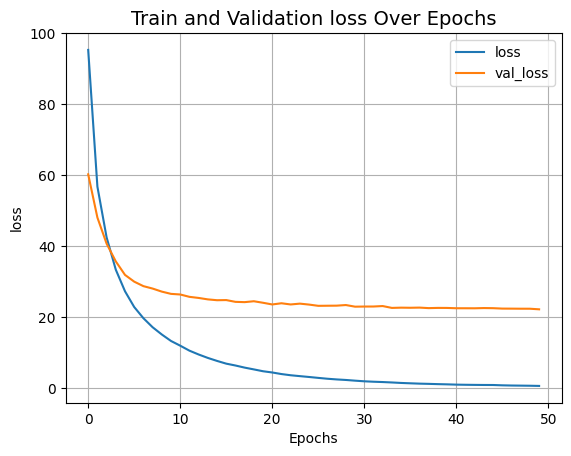

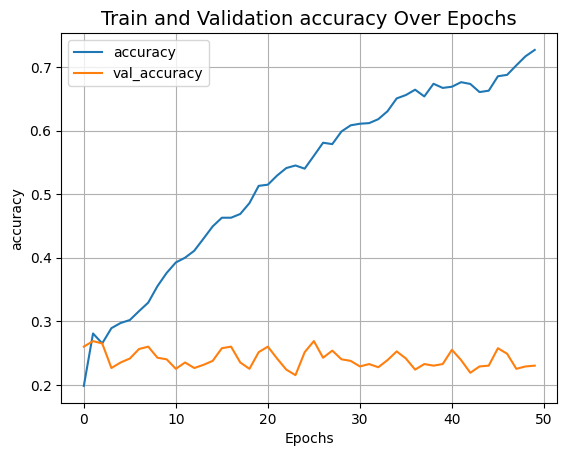

In [34]:
plot_result("loss")
plot_result("accuracy")

#### 4.2.4. Evaluate the model

From the evaluation results below we can see that wile the baseline model appears to perform well when considering the **Categorical accuracy** it performs poorly when considering the **F1-Score** and **Jaccard Similarity**.

First we need to understand the **Binary Accuracy** metric as reported by Keras. This metric treats each label as a separate binary classification problem. It calculates the percentage of correctly predicted labels (both positive and negative) across all labels and instances. High binary accuracy indicates that, on average, the model is good at deciding whether a specific label should be applied or not, but it doesn't consider the exact set of labels for each instance.

##### Diagnosing the Issue

1. **Class Imbalance**: If some labels are much more frequent than others, the model might learn to predict these labels more accurately, contributing to high binary accuracy. However, rare labels might be poorly predicted, which affects F1 scores and Jaccard similarity negatively.

2. **Label Correlations**: In real-world data, labels can be correlated (e.g., "Network Coverage" and "Service" might often appear together). If the model fails to capture these correlations, it might still achieve good binary accuracy by getting many labels right based on their individual occurrences but fail at accurately capturing the relationships between labels, which is crucial for high F1 scores and Jaccard similarity.

3. **Thresholding**: The way you convert model outputs (probabilities) into label predictions (binary) can significantly impact performance. The default threshold is 0.5, but adjusting this threshold might improve F1 scores and Jaccard similarity.

##### Improving The Model

The following are potential strategies for improving the model:

1. **Model Architecture**: Experiment with different model architectures, layers, and hyperparameters. Attention mechanisms or more sophisticated RNNs and CNNs might capture label correlations better.

2. **Class Weights**: Adjust class weights to handle imbalanced data better, making the model pay more attention to rare labels.

3. **Evaluation Metric Optimization**: Instead of optimizing for binary accuracy during training, consider optimizing directly for metrics more aligned with your actual goals, like F1 score or Jaccard index, if possible.

4. **Threshold Tuning**: Experiment with different thresholds for converting probabilities to binary labels, or consider using ranking-based metrics if thresholding proves problematic.


> ❗️As discussed in a previous section, the dataset is imbalanced at both the label and label combination levels. This imbalance is likely contributing to the discrepancy between the binary accuracy and the F1 scores and Jaccard similarity.

In [35]:
_, binary_acc, accuracy = baseline_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(binary_acc * 100, 2)}%.")
print(f"Accuracy on the test set: {round(accuracy * 100, 2)}%.")

2/2 [==============================] - 0s 5ms/step - loss: 24.4562 - binary_accuracy: 0.8157 - accuracy: 0.2328
Categorical accuracy on the test set: 81.57%.
Accuracy on the test set: 23.28%.


Calculate the relevant evaluation metrics using the `Evaluation` class for a more detailed analysis.

In [36]:
show_model_evaluation(baseline_model,
                      epochs=epochs,
                      verbose=0,
                      description="Feed-Forward",
                      loss_function="Binary Crossentropy",
                      output=model_output)

--- Training ------------------------
F1 Score (Macro-Average)   	0.100
F1 Score (Weighted-Average)	0.212
Average Jaccard Similarity 	0.142
Subset Accuracy            	0.017
Binary Accuracy            	0.966
Accuracy                   	0.724

--- Validation ----------------------
F1 Score (Macro-Average)   	0.129
F1 Score (Weighted-Average)	0.250
Average Jaccard Similarity 	0.152
Subset Accuracy            	0.010
Binary Accuracy            	0.822
Accuracy                   	0.230

--- Test ----------------------------
F1 Score (Macro-Average)   	0.106
F1 Score (Weighted-Average)	0.232
Average Jaccard Similarity 	0.138
Subset Accuracy            	0.010
Binary Accuracy            	0.816
Accuracy                   	0.233


### 4.3. Class Weights

 The distribution of classes can significantly impact model performance. As already seen, our dataset exhibit a class imbalance, where some classes are underrepresented compared to others. This imbalance can lead to models that are biased towards the majority class, at the expense of accurately predicting minority class instances.

To mitigate this issue, we will experiment with class weights. Class weighting is a technique that adjusts the importance of each class during the training process, based on the inverse of their frequencies. By assigning higher weights to underrepresented classes, the model is penalized more for misclassifying these classes, encouraging it to pay more attention to them.

The method we will use involves calculating the class weights based on the training dataset's class distribution. These weights are then applied to the loss function during model training, effectively altering the training dynamics to favor an equitable representation of classes in the model's predictions. This approach is straightforward to implement and has been shown to improve model performance on imbalanced datasets

#### 4.3.1. Calculate Label Weights

First, we need to determine the frequency of each label in your dataset. This involves counting how many times each label appears across all samples.

In [37]:
def calculate_label_weights(y_train):
    """Calculate label weights based on inverse label frequency."""
    label_frequencies = np.sum(y_train, axis=0)
    label_weights = len(y_train) / (label_frequencies + 1e-9)  # Adding a small value to avoid division by zero
    label_weights /= np.min(label_weights)  # Optional normalization
    return label_weights

In [38]:
y_train = y_train = np.concatenate([label_batch.numpy() for _, label_batch in train_dataset], axis=0)
label_weights = calculate_label_weights(y_train)

#### 4.3.2. Label Weights in Loss Calculation

Define a custom loss metric based on `tf.keras.losses.binary_crossentropy` that incorporates the calculated class weights.

In [39]:
def weighted_binary_crossentropy(y_true, y_pred, weights):
    """
    Weighted binary cross-entropy loss for multi-label classification.
    
    Args:
    - y_true: True labels.
    - y_pred: Predictions.
    - weights: Array of shape (num_labels,) containing the weight for each label.
    
    Returns:
    - Weighted loss.
    """
    # Convert weights to a tensor
    weights = tf.constant(weights, dtype=tf.float32)
    
    # Calculate the binary cross-entropy loss
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    
    # Expand weights to match the shape of y_true and y_pred
    weights = tf.reduce_mean(weights * y_true, axis=-1)
    
    # Apply the weights
    weighted_bce = bce * weights
    
    # Return the mean loss
    return tf.reduce_mean(weighted_bce)

def get_weighted_loss(weights):
    """Implements wrapping the custom loss with the calculated weights"""
    def loss(y_true, y_pred):
        return weighted_binary_crossentropy(y_true, y_pred, weights)
    return loss

#### 4.3.3. Model Training

In [40]:
# we will use the same baseline model architecture as before
weight_model = create_baseline_model()

# compile the model with the new metrics
weight_model.compile(
    loss=get_weighted_loss(label_weights),
    optimizer='adam',
    metrics=['binary_accuracy', 'accuracy'])

In [41]:
# train the model
history = weight_model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=epochs,
    verbose=0
)

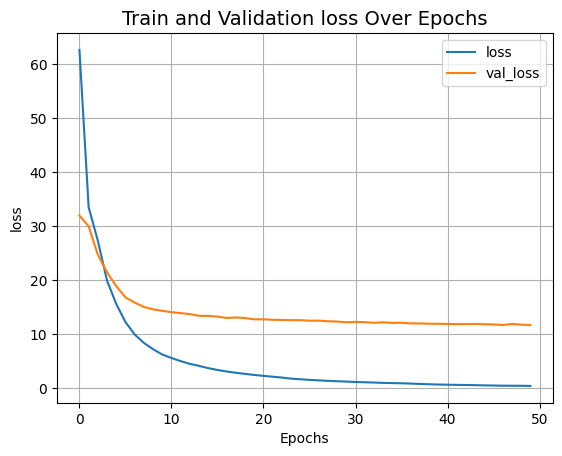

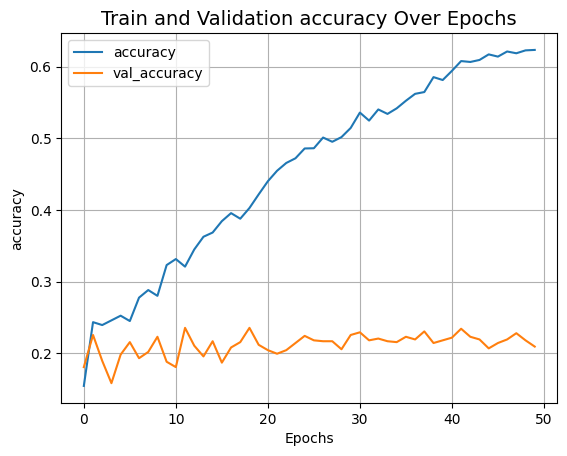

In [42]:
# plot the training history
plot_result("loss")
plot_result("accuracy")

In [43]:
show_model_evaluation(weight_model,
                      epochs=epochs,
                      verbose=0,
                      description="Feed-Forward",
                      loss_function="Weighted Binary Crossentropy",
                      output=model_output)

--- Training ------------------------
F1 Score (Macro-Average)   	0.096
F1 Score (Weighted-Average)	0.195
Average Jaccard Similarity 	0.121
Subset Accuracy            	0.011
Binary Accuracy            	0.944
Accuracy                   	0.591

--- Validation ----------------------
F1 Score (Macro-Average)   	0.117
F1 Score (Weighted-Average)	0.222
Average Jaccard Similarity 	0.130
Subset Accuracy            	0.006
Binary Accuracy            	0.819
Accuracy                   	0.209

--- Test ----------------------------
F1 Score (Macro-Average)   	0.108
F1 Score (Weighted-Average)	0.222
Average Jaccard Similarity 	0.128
Subset Accuracy            	0.005
Binary Accuracy            	0.814
Accuracy                   	0.231


#### 4.3.4. Analysis

It is clear that the `binary_accuracy` metric is completely inappropriate for this multi-label classification task. Even when we attempt to apply class weights to the loss function, the `binary_accuracy` metric keeps improving, but the important metrics like `f1_score` and `jaccard_score` do not improve.

An alternative metric list [Focal Loss](https://arxiv.org/abs/1708.02002) could potentially be considered.

### 4.4. Focal Loss

In the section we will experiment with using using Focal Loss as an alternative loss function. Additional training metrics are also introduced to monitor the model's performance.

#### 4.4.1. Model Training

In [44]:
# we will use the same baseline model architecture as before
focal_model = create_baseline_model()

# compile the model with the new metrics
focal_model.compile(
    loss=keras_cv.losses.FocalLoss(alpha=0.5, gamma=2, label_smoothing=0),
    optimizer='adam',
    metrics=[
        'binary_accuracy',
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')])

In [45]:
# train the model
history = focal_model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=epochs,
    verbose=0
)

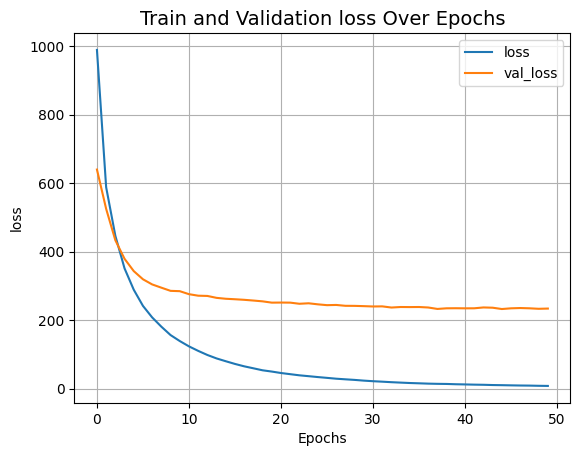

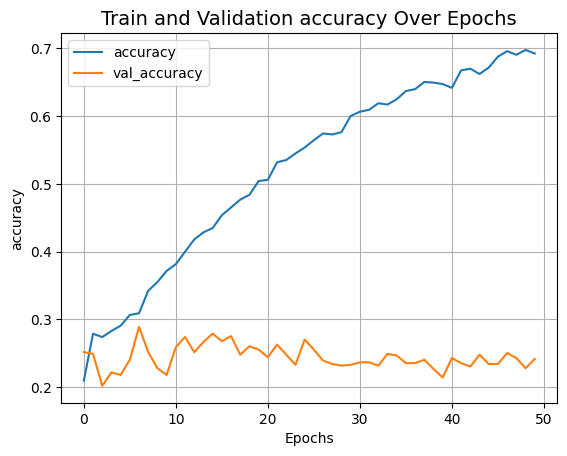

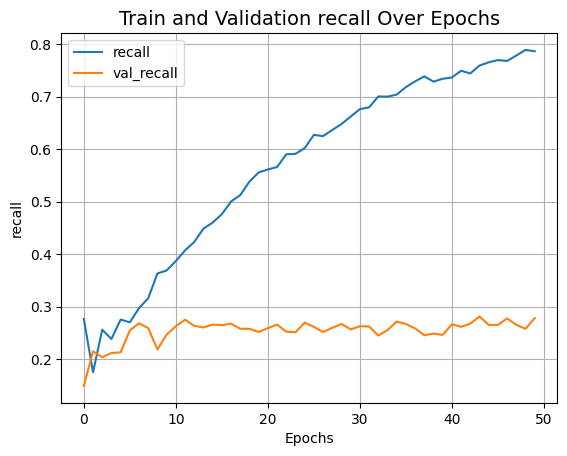

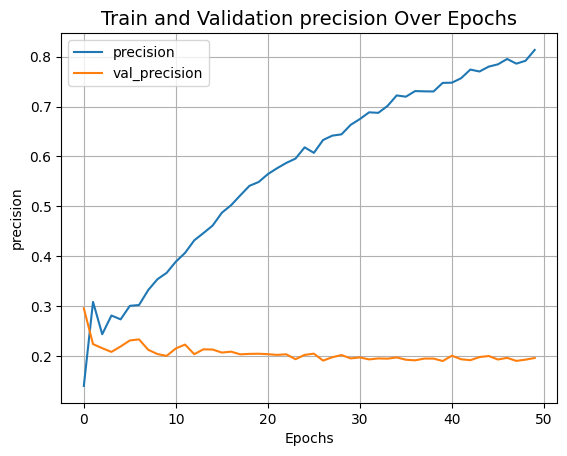

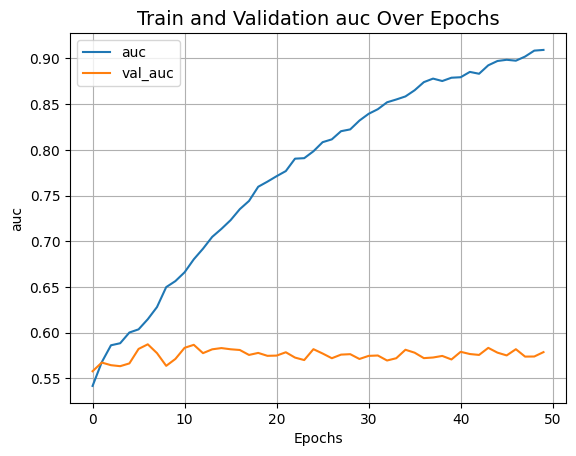

In [46]:
plot_result("loss")
plot_result("accuracy")
plot_result("recall")
plot_result("precision")
plot_result("auc")

In [47]:
show_model_evaluation(focal_model,
                      epochs=epochs,
                      verbose=0,
                      description="Feed-Forward",
                      loss_function="Focal Loss",
                      output=model_output)

--- Training ------------------------
F1 Score (Macro-Average)   	0.104
F1 Score (Weighted-Average)	0.218
Average Jaccard Similarity 	0.145
Subset Accuracy            	0.014
Binary Accuracy            	0.961
Accuracy                   	0.733

--- Validation ----------------------
F1 Score (Macro-Average)   	0.122
F1 Score (Weighted-Average)	0.246
Average Jaccard Similarity 	0.147
Subset Accuracy            	0.011
Binary Accuracy            	0.811
Accuracy                   	0.242

--- Test ----------------------------
F1 Score (Macro-Average)   	0.113
F1 Score (Weighted-Average)	0.239
Average Jaccard Similarity 	0.136
Subset Accuracy            	0.005
Binary Accuracy            	0.812
Accuracy                   	0.256


#### 4.4.2. Analysis

Unfortunately the alternative loss function also did not improve the model's performance. 

### 4.5. Surrogate F1 Score Loss Function

The root cause of the challenges we are facing is the loss function used for training does not align well with the performance metrics of interest (e.g., F1 Score, Jaccard Similarity, Subset Accuracy). `binary_crossentropy` effectively captures the probability error for each label independently, but it does not account for the interdependencies between labels or the balance among different classes which are crucial in a multi-label context. Consequently, the model may achieve a low value of binary_crossentropy indicating good performance from an optimization standpoint, yet it might score poorly on the more nuanced performance metrics that are critical for evaluating the practical effectiveness of the model.

In this project the loss function should incorporate elements from the evaluation metrics that we care about (like F1 Score, Jaccard Similarity, or Hamming Loss). For instance, F1 Score considers both precision and recall, making it a more balanced metric for evaluating performance across diverse classes. However, since F1 Score is not differentiable and thus not directly usable in gradient-based optimization, we can create a differentiable surrogate that approximates it.

n light of the challenges associated with aligning loss functions with evaluation metrics in multi-label classification tasks, our project will explore the implementation and effectiveness of a Smooth F1 Score based on the innovative approach presented in the [paper](https://arxiv.org/abs/2108.10566) _"sigmoidF1: A Smooth F1 Score Surrogate Loss for Multilabel Classification"_ by Gabriel Bénédict, Vincent Koops, Daan Odijk, and Maarten de Rijke. This paper introduces the sigmoidF1 loss function, a novel approximation of the F1 Score designed specifically for multi-label classification scenarios. Unlike traditional loss functions, sigmoidF1 is smooth and differentiable, making it suitable for optimization through stochastic gradient descent while directly targeting the nuances of multi-label metrics. The authors demonstrate the superior performance of the sigmoidF1 loss function across various datasets, including both text and image domains, showcasing its ability to more accurately estimate label propensities and counts compared to conventional approaches. By experimenting with the sigmoidF1 model, we aim to bridge the gap between optimization during training and the actual performance metrics that matter, potentially enhancing the model's practical effectiveness in handling complex multi-label classification tasks

#### 4.5.1. sigmoidF1

Code taken from: https://github.com/gabriben/metrics-as-losses/blob/main/VLAP/sigmoidF1.py

In [48]:
def sigmoidF1(y, y_hat, from_logits = True):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        -
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    S = -10 # sigmoid s-shape hyperparam (initial -10)
    E = 1 # sigmoid offset hyperparam (initial 1)

    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    
    if from_logits == True:
        # y = tf.nn.softmax(y)
        #y_hat = tf.nn.softmax(y_hat)
        y_hat = tf.math.sigmoid(y_hat) # (initial)
        #y_hat = tf.math.exp(y_hat) / (tf.math.exp(y_hat) + 1)

    #tf.print(y_hat)
        
    b = tf.constant(S, tf.float32)
    c = tf.constant(E, tf.float32)
    sig = 1 / (1 + tf.math.exp(b * (y_hat + c)))
    #tf.print(sig)
    tp = tf.reduce_sum(sig * y, axis=0)
    fp = tf.reduce_sum(sig * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - sig) * y, axis=0)

    sigmoid_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - sigmoid_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macroCost = tf.reduce_mean(cost) # average on all labels
    return macroCost

#### 4.5.2. Model Training

The initial experiment shows a highly volatile loss on the training data, this could be an indication of the following:

1. The learning rate is too high (initial `0.001`)
2. Batch size too small (initial `150`)
3. Model Capacity: The model might be too complex (overfitting) or too simple (underfitting) for the given task (initial `[512]`).

In [49]:
# we will use the same baseline model architecture as before
f1_model = make_baseline_model(
        text_vectorizer_layer,
        output_units=len(lookup.get_vocabulary()),
        dense_units=[1024], # (initial [512])
        dense_activation='relu'
    )

# compile the model with the new metrics
f1_model.compile(
    loss=sigmoidF1,
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[
        'binary_accuracy',
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')])

In [50]:
# train the model
history = f1_model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=epochs,
    verbose=0
)

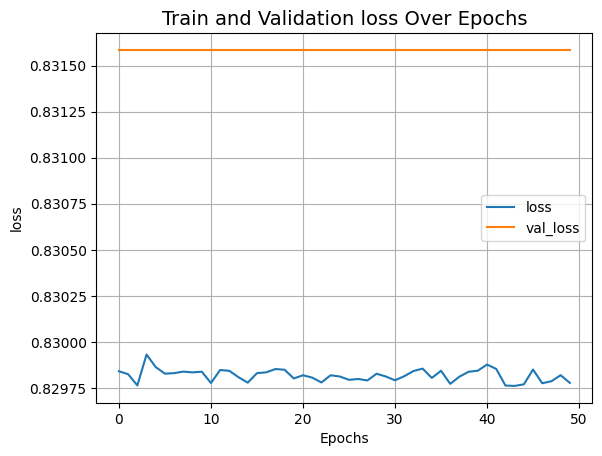

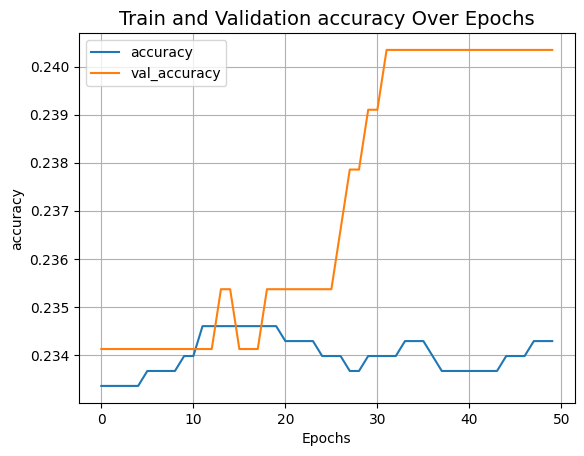

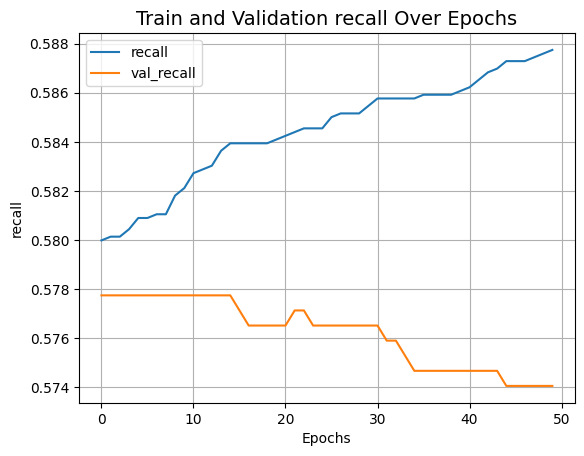

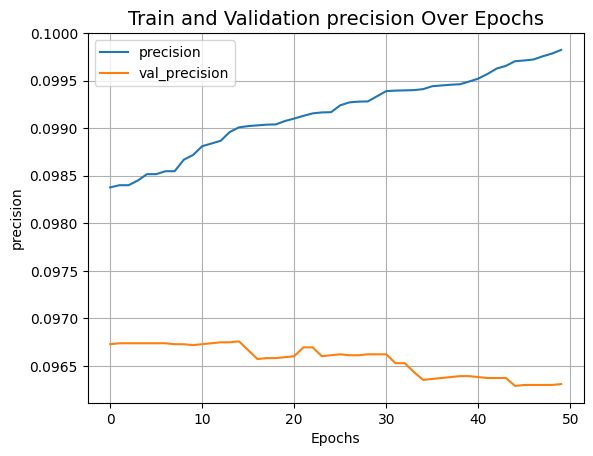

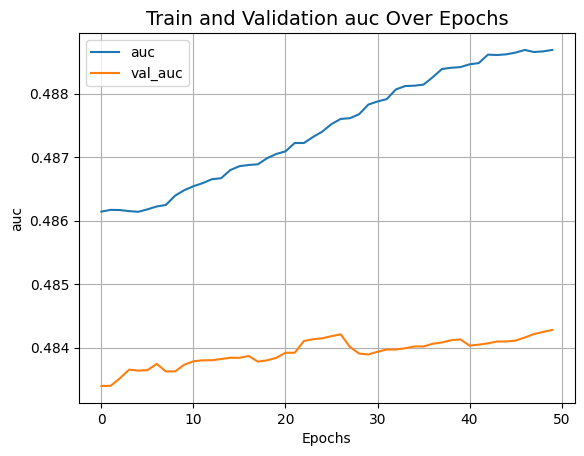

In [51]:
plot_result("loss")
plot_result("accuracy")
plot_result("recall")
plot_result("precision")
plot_result("auc")

In [52]:
show_model_evaluation(f1_model,
                      epochs=epochs,
                      verbose=0,
                      description="Feed-Forward",
                      loss_function="Sigmoid F1",
                      output=model_output)

--- Training ------------------------
F1 Score (Macro-Average)   	0.151
F1 Score (Weighted-Average)	0.290
Average Jaccard Similarity 	0.096
Subset Accuracy            	0.000
Binary Accuracy            	0.416
Accuracy                   	0.234

--- Validation ----------------------
F1 Score (Macro-Average)   	0.144
F1 Score (Weighted-Average)	0.285
Average Jaccard Similarity 	0.092
Subset Accuracy            	0.000
Binary Accuracy            	0.411
Accuracy                   	0.240

--- Test ----------------------------
F1 Score (Macro-Average)   	0.148
F1 Score (Weighted-Average)	0.289
Average Jaccard Similarity 	0.095
Subset Accuracy            	0.000
Binary Accuracy            	0.416
Accuracy                   	0.244


#### 4.5.3. Analysis

While the `sigmoidF1` appears to be more closely aligned with the training objective, it does not improve the model's performance, and in some aspects (Subset Accuracy) it performs worse than the previous models. In future work we well revisit this approach.

This concludes experimentation attempting to handle the class imbalance either through class weights or alternative loss functions. 

### 4.6. Embedding Layer

For text classification, a common approach is to use an embedding layer followed by one or more dense layers. In this section we will extend our original baseline model by adding an embedding layer. The embedding layer learns a dense representation for each token in the input text. This dense representation is then used as the input to the following dense layers.

In [53]:
def make_model(
        vectorization_layer: layers.TextVectorization,
        output_units:int,
        dense_units:List[int]=None,
        embedding_dim:int=None,
        bidirectional_lstm:List[int]=None,
        l2_reg:List[float]=None,
        dropout_rate:List[float]=None,
        dense_activation:Optional[str]='relu') -> keras.Model:
    """Create a simple feed-forward model that can be used as a baseline."""
    model = keras.Sequential()

    # add the vectorization layer
    model.add(vectorization_layer)

    # add the embedding layer
    if embedding_dim is not None:
        model.add(layers.Embedding(
            input_dim=len(vectorization_layer.get_vocabulary()),
            output_dim=embedding_dim))

    # add bidirectional LSTM layers
    if bidirectional_lstm is not None:
        for i, units in enumerate(bidirectional_lstm):
            lstm_layer = layers.Bidirectional(
                layers.LSTM(units, return_sequences=(i < len(bidirectional_lstm) - 1)))
            
            model.add(lstm_layer)
            # add regularization if provided
            if l2_reg is not None:
                lstm_layer.kernel_regularizer=keras.regularizers.l2(l2_reg[i])

    # add dense layers
    if dense_units is not None:
        # add a flatten label
        model.add(layers.Flatten())      
        #model.add(keras.layers.GlobalMaxPooling1D())

        # add the dense layers
        for i, units in enumerate(dense_units):
            dense_layer = layers.Dense(units, activation=dense_activation)

            # add regularization if provided
            if l2_reg is not None:
                dense_layer.kernel_regularizer=keras.regularizers.l2(l2_reg[i])

            model.add(dense_layer)

            # add the dropout layer
            if dropout_rate is not None:
                model.add(layers.Dropout(dropout_rate[i]))

    # add the output layer
    model.add(layers.Dense(output_units, activation='sigmoid', name='output'))

    return model

#### 4.6.1. Extra Layer Only

We will use the same model architecture as the baseline model, but with the addition of an embedding layer. None of the other model parameters will be changed for this initial experiment.

In [54]:
# create the model
model = make_model(
    vectorization_layer=text_vectorizer_layer,
    output_units=len(lookup.get_vocabulary()), 
    embedding_dim=16, # (initial 16)
    dense_units=[512],
    dense_activation='relu'
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 100)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 100, 16)           190272    
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               819712    
                                                                 
 output (Dense)              (None, 20)                10260     
                                                                 
Total params: 1020244 (3.89 MB)
Trainable params: 1020244 (3.89 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [55]:
# compile the model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0),
    optimizer='adam',
    metrics=['accuracy','binary_accuracy'])

# train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    verbose=0
)

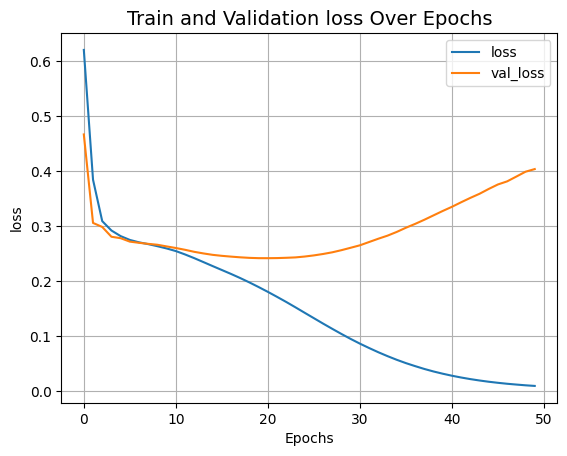

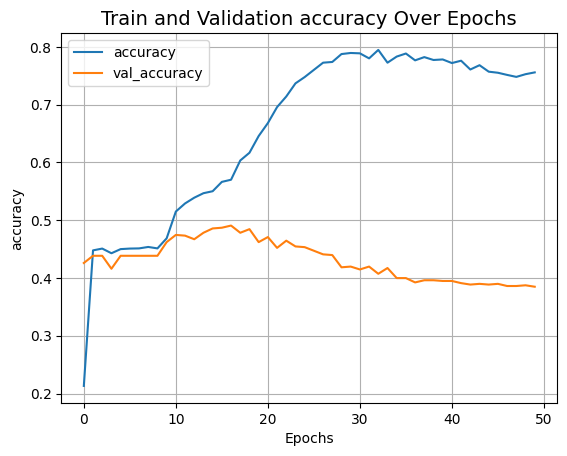

In [56]:
plot_result("loss")
plot_result("accuracy")
#plot_result("binary_accuracy")

In [57]:
model.evaluate(test_dataset)

2/2 [==============================] - 0s 6ms/step - loss: 0.4229 - accuracy: 0.3821 - binary_accuracy: 0.9010


[0.42285534739494324, 0.3820895552635193, 0.9009950160980225]

In [58]:
show_model_evaluation(model,
                      epochs=epochs,
                      verbose=0,
                      description="Embedding Layer",
                      loss_function="Binary Crossentropy",
                      output=model_output)

--- Training ------------------------
F1 Score (Macro-Average)   	0.107
F1 Score (Weighted-Average)	0.216
Average Jaccard Similarity 	0.150
Subset Accuracy            	0.024
Binary Accuracy            	0.750
Accuracy                   	0.999

--- Validation ----------------------
F1 Score (Macro-Average)   	0.160
F1 Score (Weighted-Average)	0.353
Average Jaccard Similarity 	0.276
Subset Accuracy            	0.081
Binary Accuracy            	0.385
Accuracy                   	0.905

--- Test ----------------------------
F1 Score (Macro-Average)   	0.149
F1 Score (Weighted-Average)	0.335
Average Jaccard Similarity 	0.260
Subset Accuracy            	0.069
Binary Accuracy            	0.382
Accuracy                   	0.901


##### Optimal Epochs

Train a model for the optimal number of epochs and compare the results.

In [59]:
# after how many epochs does the model start to overfit
val_loss = history.history['val_loss']
optimal_epochs = np.argmin(val_loss)

print(f'Overfitting at {optimal_epochs} epochs.')

Overfitting at 20 epochs.


In [60]:
# create the model
model = make_model(
    vectorization_layer=text_vectorizer_layer,
    output_units=len(lookup.get_vocabulary()),
    embedding_dim=16,
    dense_units=[512],
    dense_activation='relu'
)

# compile the model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0),
    optimizer='adam',
    metrics=['binary_accuracy', 'accuracy'])

# train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=optimal_epochs,
    verbose=0
)

# evaluate the model
print(model.evaluate(test_dataset))

# show the evaluation
show_model_evaluation(model, 
                      verbose=0,
                      epochs=optimal_epochs,
                      description="Embedding Layer",
                      loss_function="Binary Crossentropy",
                      output=model_output)

2/2 [==============================] - 0s 6ms/step - loss: 0.2454 - binary_accuracy: 0.9075 - accuracy: 0.4915
[0.24535273015499115, 0.9075124263763428, 0.4915422797203064]
--- Training ------------------------
F1 Score (Macro-Average)   	0.055
F1 Score (Weighted-Average)	0.169
Average Jaccard Similarity 	0.141
Subset Accuracy            	0.019
Binary Accuracy            	0.934
Accuracy                   	0.680

--- Validation ----------------------
F1 Score (Macro-Average)   	0.099
F1 Score (Weighted-Average)	0.282
Average Jaccard Similarity 	0.224
Subset Accuracy            	0.054
Binary Accuracy            	0.910
Accuracy                   	0.461

--- Test ----------------------------
F1 Score (Macro-Average)   	0.095
F1 Score (Weighted-Average)	0.270
Average Jaccard Similarity 	0.218
Subset Accuracy            	0.052
Binary Accuracy            	0.908
Accuracy                   	0.492


Using the optimal epochs results in decreased performance. This is another indication that we are not optomizing for the curret metric, and the "correct" approach as demonstrated in the Deep Learning for Python textbook or the Keras example for [multi-label classification](https://keras.io/examples/nlp/multi_label_classification/) cannot be taken as generic advice.

#### 4.6.2. Weight Regularization

From the previous plots we can see that the model is over fitting. To address this we will first introduce weight regularization to the model.

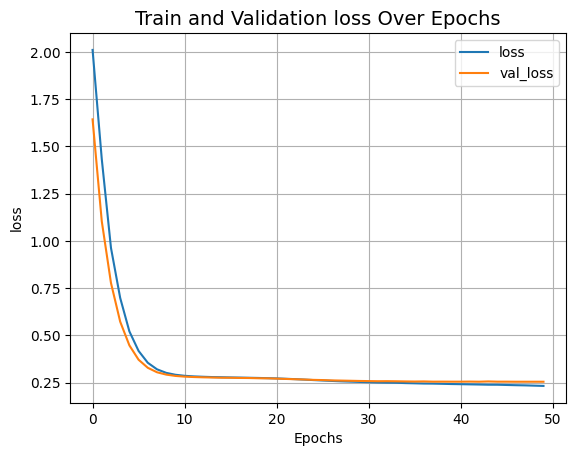

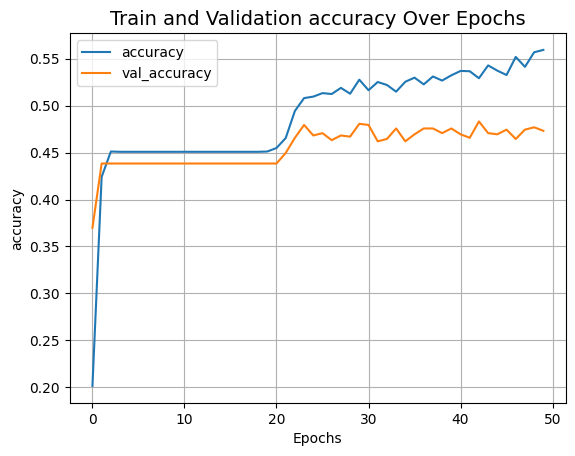

2/2 [==============================] - 0s 6ms/step - loss: 0.2571 - binary_accuracy: 0.9074 - accuracy: 0.4985
[0.2571393847465515, 0.9074130058288574, 0.49850746989250183]
--- Training ------------------------
F1 Score (Macro-Average)   	0.045
F1 Score (Weighted-Average)	0.150
Average Jaccard Similarity 	0.128
Subset Accuracy            	0.015
Binary Accuracy            	0.921
Accuracy                   	0.566

--- Validation ----------------------
F1 Score (Macro-Average)   	0.088
F1 Score (Weighted-Average)	0.261
Average Jaccard Similarity 	0.211
Subset Accuracy            	0.050
Binary Accuracy            	0.909
Accuracy                   	0.473

--- Test ----------------------------
F1 Score (Macro-Average)   	0.085
F1 Score (Weighted-Average)	0.254
Average Jaccard Similarity 	0.212
Subset Accuracy            	0.041
Binary Accuracy            	0.907
Accuracy                   	0.499


In [62]:
# create the model
model = make_model(
    vectorization_layer=text_vectorizer_layer,
    output_units=len(lookup.get_vocabulary()),
    embedding_dim=16,
    dense_units=[512],
    l2_reg=[0.002],
    dense_activation='relu'
)

# compile the model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0),
    optimizer='adam',
    metrics=['binary_accuracy', 'accuracy'])

# train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    verbose=0
)

# plot the training history
plot_result("loss")
plot_result("accuracy")

# evaluate the model
print(model.evaluate(test_dataset))

# show the evaluation
show_model_evaluation(model,
                      verbose=0,
                      epochs=epochs,
                      description="Embedding Layer: Regularization (weight) ",
                      loss_function="Binary Crossentropy",
                      output=model_output)

#### 4.6.3. Dropout Regularization

In the previous section we can see that weight regularization combats over fitting up to a point, but when trained for more epochs we can still see this issue. To address this we will introduce dropout regularization to the model.

At this point we also reduce the dense units from `512` to `128` to reduce the model complexity, as over fitting did not improve in the initial experiment with dropout.

>❗️It is important to note though that we are actually now getting worse performing models as measured by the nuanced metrics.

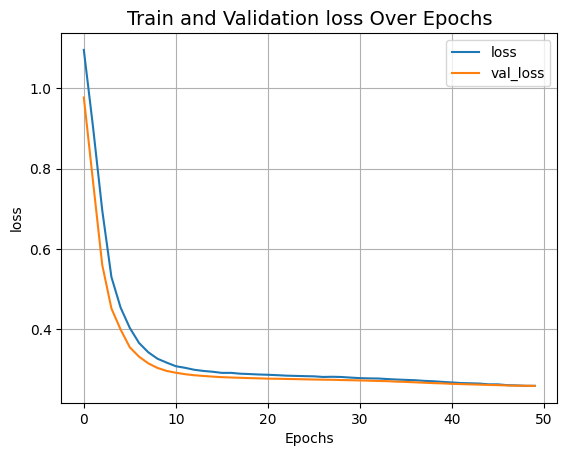

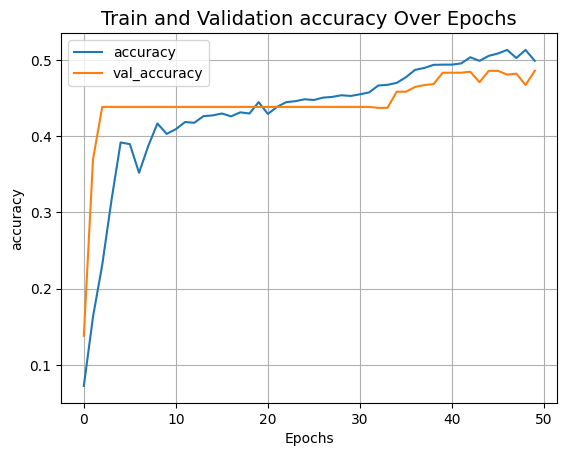

2/2 [==============================] - 0s 5ms/step - loss: 0.2608 - binary_accuracy: 0.9049 - accuracy: 0.4975
[0.26081210374832153, 0.9048755764961243, 0.49751242995262146]
--- Training ------------------------
F1 Score (Macro-Average)   	0.038
F1 Score (Weighted-Average)	0.136
Average Jaccard Similarity 	0.116
Subset Accuracy            	0.009
Binary Accuracy            	0.909
Accuracy                   	0.526

--- Validation ----------------------
F1 Score (Macro-Average)   	0.069
F1 Score (Weighted-Average)	0.219
Average Jaccard Similarity 	0.180
Subset Accuracy            	0.040
Binary Accuracy            	0.906
Accuracy                   	0.486

--- Test ----------------------------
F1 Score (Macro-Average)   	0.068
F1 Score (Weighted-Average)	0.216
Average Jaccard Similarity 	0.181
Subset Accuracy            	0.034
Binary Accuracy            	0.905
Accuracy                   	0.498


In [63]:
# create the model
model = make_model(
    vectorization_layer=text_vectorizer_layer,
    output_units=len(lookup.get_vocabulary()),
    embedding_dim=16,
    dense_units=[128],
    l2_reg=[0.002],
    dropout_rate=[0.5],
    dense_activation='relu'
)

# compile the model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0),
    optimizer='adam',
    metrics=['binary_accuracy', 'accuracy'])

# train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    verbose=0
)

# plot the training history
plot_result("loss")
plot_result("accuracy")

# evaluate the model
print(model.evaluate(test_dataset))

# show the evaluation
show_model_evaluation(model,
                      verbose=0,
                      epochs=epochs,
                      description="Embedding Layer: Regularization (dropout)",
                      loss_function="Binary Crossentropy",
                      output=model_output)

#### 4.6.4. Regularization with sigmoidF1

We will now experiment with the custom `sigmoidF1` loss function in combination with the dropout regularization.

1. From the experiment below we can see that the `sigmoidF1` performs better now that we have reduced the model capacity and introduced regularization.

2. It is also worth noting that we now achive the highest `F1 Score (Weighted-Average)` of all the models. However, this is at the expense of the `Subset Accuracy` which has now dropped to zero. 

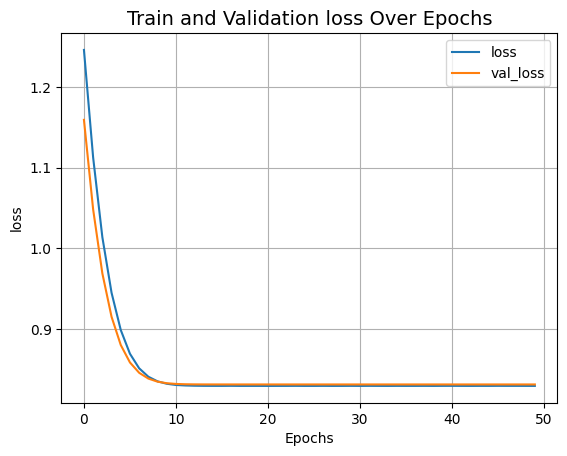

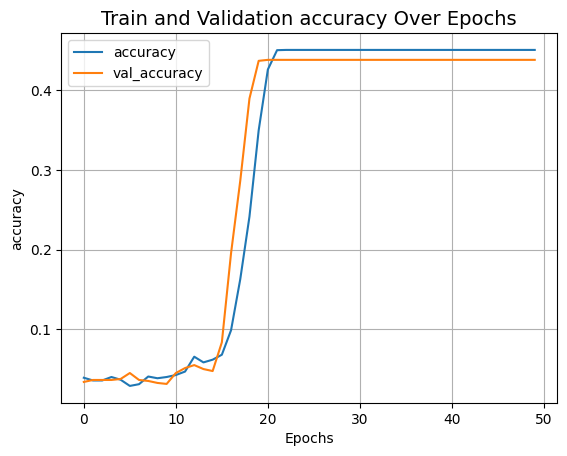

2/2 [==============================] - 0s 6ms/step - loss: 0.8302 - binary_accuracy: 0.3362 - accuracy: 0.4567
[0.8301895260810852, 0.33616915345191956, 0.4567164182662964]
--- Training ------------------------
F1 Score (Macro-Average)   	0.157
F1 Score (Weighted-Average)	0.329
Average Jaccard Similarity 	0.127
Subset Accuracy            	0.000
Binary Accuracy            	0.339
Accuracy                   	0.451

--- Validation ----------------------
F1 Score (Macro-Average)   	0.155
F1 Score (Weighted-Average)	0.331
Average Jaccard Similarity 	0.125
Subset Accuracy            	0.000
Binary Accuracy            	0.337
Accuracy                   	0.438

--- Test ----------------------------
F1 Score (Macro-Average)   	0.155
F1 Score (Weighted-Average)	0.332
Average Jaccard Similarity 	0.125
Subset Accuracy            	0.000
Binary Accuracy            	0.336
Accuracy                   	0.457


In [64]:
# create the model
model = make_model(
    vectorization_layer=text_vectorizer_layer,
    output_units=len(lookup.get_vocabulary()),
    embedding_dim=16,
    dense_units=[128],
    l2_reg=[0.002],
    dropout_rate=[0.5],
    dense_activation='relu'
)

# compile the model
model.compile(
    loss=sigmoidF1,
    optimizer='adam',
    metrics=['binary_accuracy', 'accuracy'])

# train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    verbose=0
)

# plot the training history
plot_result("loss")
plot_result("accuracy")

# evaluate the model
print(model.evaluate(test_dataset))

# show the evaluation
show_model_evaluation(model,
                      verbose=0,
                      epochs=epochs,
                      description="Embedding Layer: Regularization (dropout)",
                        loss_function="Sigmoid F1",
                        output=model_output)

### 4.7. TF-IDF Vectorization

In this section we will experiment with using the `tf-idf` vectorization method instead of using an embedding layer. This is a simple, but quite effective technique in NLP text classification tasks.

In [65]:
# create the vectorization layer
tf_vectorizer_layer = create_vectorizer(
    df_preprocess.review_text.values,
    max_tokens=vocabulary_size,
    output_mode='tf-idf'
)

#### 4.7.1 Model Evaluation

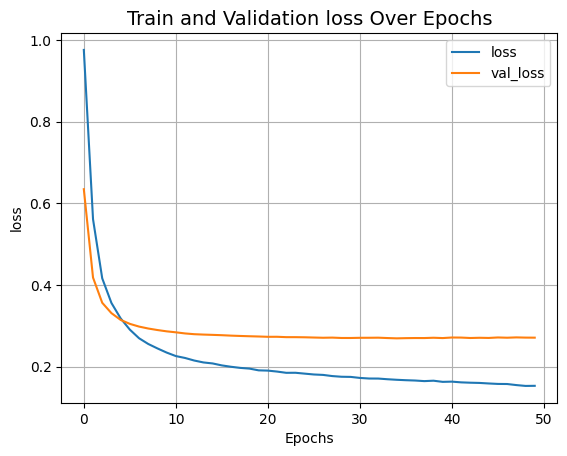

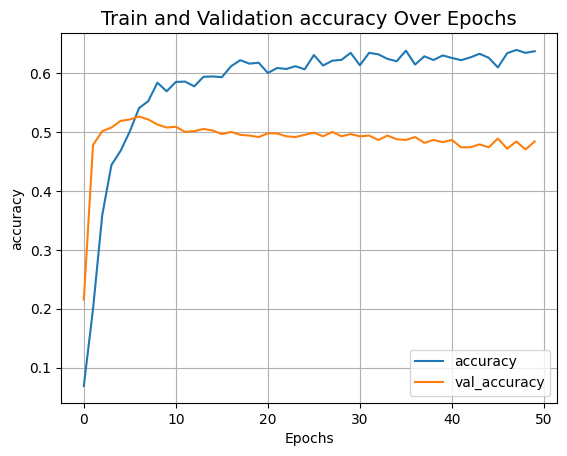

2/2 [==============================] - 0s 10ms/step - loss: 0.2722 - binary_accuracy: 0.9182 - accuracy: 0.4687
[0.2722322940826416, 0.9182088971138, 0.4686567187309265]
--- Training ------------------------
F1 Score (Macro-Average)   	0.090
F1 Score (Weighted-Average)	0.210
Average Jaccard Similarity 	0.154
Subset Accuracy            	0.022
Binary Accuracy            	0.979
Accuracy                   	0.723

--- Validation ----------------------
F1 Score (Macro-Average)   	0.219
F1 Score (Weighted-Average)	0.441
Average Jaccard Similarity 	0.360
Subset Accuracy            	0.117
Binary Accuracy            	0.920
Accuracy                   	0.484

--- Test ----------------------------
F1 Score (Macro-Average)   	0.209
F1 Score (Weighted-Average)	0.422
Average Jaccard Similarity 	0.344
Subset Accuracy            	0.103
Binary Accuracy            	0.918
Accuracy                   	0.469


In [66]:
# create the model
model = make_model(
    vectorization_layer=tf_vectorizer_layer,
    output_units=len(lookup.get_vocabulary()),
    dense_units=[128],
    l2_reg=[0.002],
    dropout_rate=[0.5],
    dense_activation='relu'
)

# compile the model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0),
    optimizer='adam',
    metrics=['binary_accuracy', 'accuracy'])

# train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    verbose=0
)

# plot the training history
plot_result("loss")
plot_result("accuracy")

# evaluate the model
print(model.evaluate(test_dataset))

# show the evaluation
show_model_evaluation(model,
                      verbose=0,
                      epochs=epochs,
                      description="Embedding Layer: TF-IDF",
                      loss_function="Binary Crossentropy",
                      output=model_output)

#### 4.7.2. Analysis

It is significant to note that by using the `tf-idf` we are able to outperform the Regularized embedding model with the binary crossentropy loss function.

> This could indicate that our training set is too small to effectively learn the token embeddings.

Specifically in the **Validation** and **Test** sets we now see the highes `F1 Score (Weighted-Average)` of all the models. However this is not reflected in the training set where we would have expected the highest scores, once again probably a reflection of the class imbalance. 

> In later sections it might be useful to experiment with **k-fold cross validation** to get a better understanding of the model's performance.

### 4.8. Bidirectional LSTM

In this experiment we will use a Bidirectional LSTM model to see if we can improve the model's performance. Bidirectional LSTMs are a type of recurrent neural network that can capture dependencies in both directions of a sequence, making them well-suited for text classification tasks.

In [68]:
# from numba import cuda

# device = cuda.get_current_device()
#device.reset()
# K.clear_session()

#### 4.8.1 LSTM Only

Create a model with no dense layers, only a single LSTM layer.

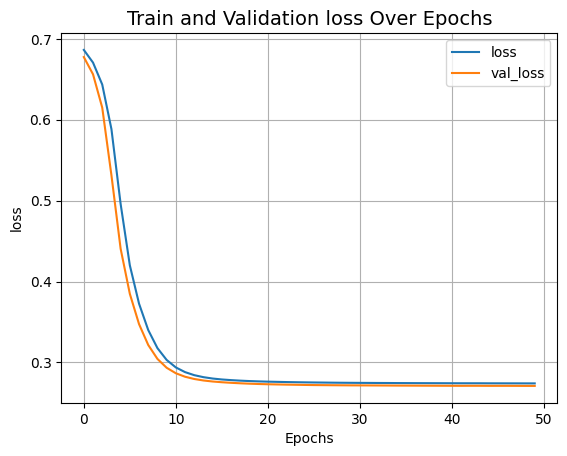

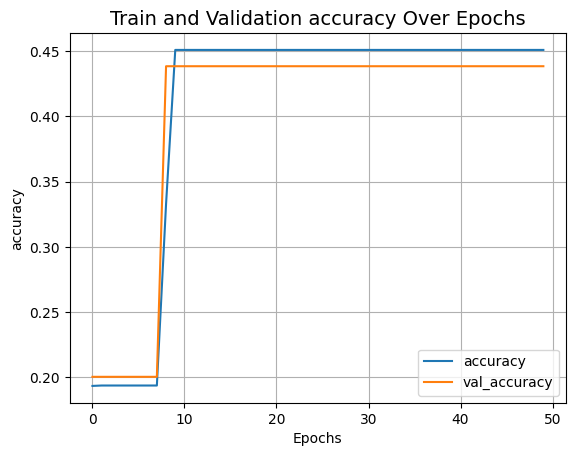

2/2 [==============================] - 0s 177ms/step - loss: 0.2728 - binary_accuracy: 0.8976 - accuracy: 0.4567
[0.2727576196193695, 0.8976119160652161, 0.4567164182662964]
--- Training ------------------------
F1 Score (Macro-Average)   	0.000
F1 Score (Weighted-Average)	0.000
Average Jaccard Similarity 	0.000
Subset Accuracy            	0.000
Binary Accuracy            	0.898
Accuracy                   	0.451

--- Validation ----------------------
F1 Score (Macro-Average)   	0.000
F1 Score (Weighted-Average)	0.000
Average Jaccard Similarity 	0.000
Subset Accuracy            	0.000
Binary Accuracy            	0.899
Accuracy                   	0.438

--- Test ----------------------------
F1 Score (Macro-Average)   	0.000
F1 Score (Weighted-Average)	0.000
Average Jaccard Similarity 	0.000
Subset Accuracy            	0.000
Binary Accuracy            	0.898
Accuracy                   	0.457


In [69]:
# create the model
model = make_model(
    vectorization_layer=tf_vectorizer_layer,
    output_units=len(lookup.get_vocabulary()),
    embedding_dim=16,
    bidirectional_lstm=[16],
    l2_reg=[0.002],
    dense_activation='relu'
)

# compile the model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0),
    optimizer='adam',
    metrics=['binary_accuracy', 'accuracy'])

# train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs, # 15
    verbose=0
)

# plot the training history
plot_result("loss")
plot_result("accuracy")

# evaluate the model
print(model.evaluate(test_dataset))

# show the evaluation
show_model_evaluation(model,
                      verbose=0,
                      epochs=epochs,
                      description="Bidirectional LSTM",
                      loss_function="Binary Crossentropy",
                      output=model_output)

#### 4.8.2. Analysis

❗️Although this model still produced comparable accuracy and binary_accuracy results, it completely fails as measured by the nuanced metrics. 

## 5. Tansformer Models

In [70]:
# Use mixed precision to speed up training
keras.mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080 Ti, compute capability 8.6


2024-03-24 13:57:10.303468: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [71]:
print(train_dataset.unbatch().take(1).get_single_element())

(<tf.Tensor: shape=(), dtype=string, numpy=b"**Vodacom poor service**\n\nOn 8 May 2023, I woke up to no internet and I called Vodacom, to-date the 19 May 2023, I still don't have internet irrespective of calling Vodacom everyday. The don't know what is a problem so everyday I'm told a different story. I'm only remembered when I call in for a feedback. 2 weeks of no internet and empty promises from Vodacom.">, <tf.Tensor: shape=(20,), dtype=float64, numpy=
array([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])>)


### 5.1. BertClassifier

In [72]:
#bert_preset = 'bert_base_en_uncased'
bert_preset = 'bert_tiny_en_uncased'

In [73]:
# get the preprocessor and backbone
preprocessor = keras_nlp.models.BertPreprocessor.from_preset(
    bert_preset, sequence_length=512)
backbone = keras_nlp.models.BertBackbone.from_preset(
    bert_preset)

# the backbone should not be trainable
backbone.trainable = False

/home/johnny/swan/miniconda3/envs/multi-intent/lib/python3.10/site-packages/keras_nlp/src/models/backbone.py:46: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/johnny/swan/miniconda3/envs/multi-intent/lib/python3.10/site-packages/keras_nlp/src/models/backbone.py:46: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [74]:
# create the input layer
inputs = keras.layers.Input(shape=(), dtype=tf.string)
preprocessing = preprocessor(inputs)
sequence = backbone(preprocessing)["sequence_output"]

# add the trainable layers
for _ in range(3):
    # sequence = keras.layers.Dense(128, activation='relu')(sequence)
    # sequence = keras.layers.Dropout(0.2)(sequence)

    sequence = keras_nlp.layers.TransformerEncoder(
        num_heads=2,
        intermediate_dim=512,
        dropout=0.1,
    )(sequence)

# Flatten the output of the transformer layer
#flattened_sequence = keras.layers.Flatten()(sequence)
flattened_sequence = keras.layers.GlobalMaxPooling1D()(sequence)

# create the output layer
output_layer = keras.layers.Dense(
    len(lookup.get_vocabulary()), 
    activation='sigmoid')(flattened_sequence)

# create the model
model = keras.Model(inputs, output_layer)

# compile the model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0),
    optimizer=keras.optimizers.AdamW(5e-5), # initial 5e-5
    metrics=['binary_accuracy', 'accuracy'],
)

# show the model summary
#print(model.summary())

# train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs, # 158 found for the highest val_accuracy
    verbose=0)

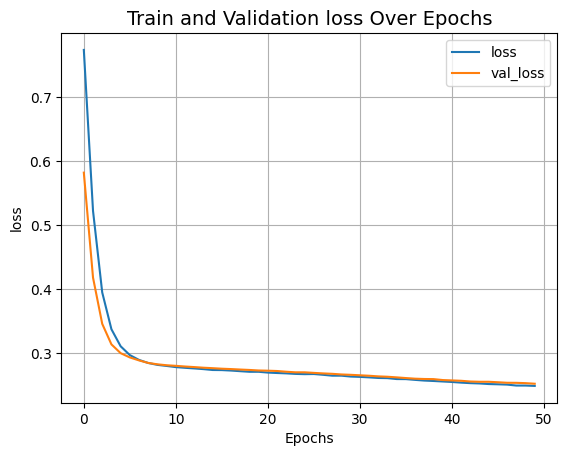

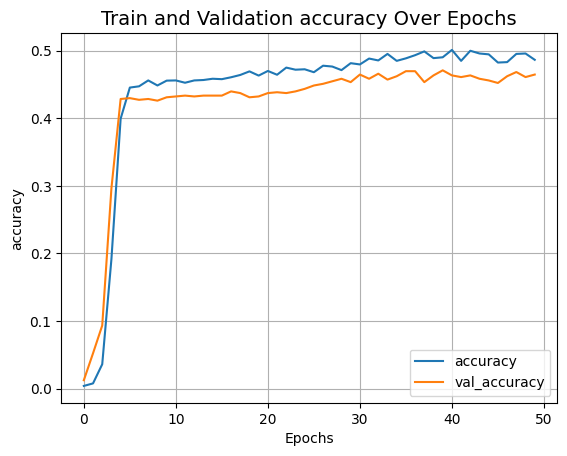

2/2 [==============================] - 0s 184ms/step - loss: 0.2548 - binary_accuracy: 0.9055 - accuracy: 0.4408
[0.25475382804870605, 0.9054726362228394, 0.44079601764678955]
--- Training ------------------------
F1 Score (Macro-Average)   	0.049
F1 Score (Weighted-Average)	0.152
Average Jaccard Similarity 	0.123
Subset Accuracy            	0.015
Binary Accuracy            	0.908
Accuracy                   	0.459

--- Validation ----------------------
F1 Score (Macro-Average)   	0.113
F1 Score (Weighted-Average)	0.298
Average Jaccard Similarity 	0.241
Subset Accuracy            	0.061
Binary Accuracy            	0.907
Accuracy                   	0.465

--- Test ----------------------------
F1 Score (Macro-Average)   	0.111
F1 Score (Weighted-Average)	0.289
Average Jaccard Similarity 	0.233
Subset Accuracy            	0.062
Binary Accuracy            	0.905
Accuracy                   	0.441


In [75]:
# plot the training history
plot_result("loss")
plot_result("accuracy")

# evaluate the model
print(model.evaluate(test_dataset))

# show the evaluation
show_model_evaluation(model,
                      verbose=0,
                      epochs=epochs,
                      description="BERT",
                      loss_function="Binary Crossentropy",
                      output=model_output)

#### 5.1.1. Analysis

In [77]:
# get the features from the test set
test_features = np.concatenate([feature_batch.numpy() for feature_batch, _ in test_dataset], axis=0)

# get the actual and predicted values
y_true = np.concatenate([label_batch.numpy() for _, label_batch in test_dataset], axis=0)
y_pred = model.predict(test_dataset)

# lookup the label values
y_true_labels = [invert_multi_hot(label, lookup) for label in y_true]
y_pred_labels = [invert_multi_hot(label, lookup) for label in y_pred > 0.3]

2/2 [==============================] - 0s 158ms/step


In [78]:
# display n random samples
n = 5
random_indices = np.random.choice(len(test_features), n, replace=False)

for i in random_indices:
    print(f"Review: {test_features[i]}")
    print(f"True labels:      {y_true_labels[i]}")
    print(f"Predicted labels: {y_pred_labels[i]}")
    print()

Review: b'**Customer Care**\n\nViwe Ndamane from Customer Care. Really took the time to be persistant in sorting out my issue even when i dropped the call and had given up. Give her a bonus :)'
True labels:      ["Customer's Feeling" 'Call Center']
Predicted labels: ["Customer's Feeling" 'Network Coverage']

Review: b"**Fibre installation**\n\nWe really have had the worst experience trying to get fibre from vodacom. Our order was approved on the 25th of November.  It took three weeks to deliver thr router and morethan a month later your customer service agents still have not activated our internet . We are told different stories on the daily snd are being sent from pillar to post,  it's been such a frustrating and daunting experience."
True labels:      ["Customer's Feeling" 'Network Coverage' 'Response']
Predicted labels: ["Customer's Feeling" 'Network Coverage']

Review: b'**Vodacom are thieves and do not refund your account on overcharges**\n\nGood day\nStill awaiting refund into my

In [79]:
# summarize the actual labels in the test set
all_true_labels = [label for labels in y_true_labels for label in labels]
pd.DataFrame(all_true_labels).value_counts()

0                 
Customer's Feeling    459
Billing               279
Cancellation          203
Network Coverage      185
Policy                144
Call Center           137
Account Management    122
Resolution            110
Response              107
Devices                80
Brand                  46
Price Plans            46
Staff Level            40
Abuse                  37
Services               17
Products               14
SIM                    13
Service                12
Other                   7
Name: count, dtype: int64

In [80]:
# summarize the predicted labels in the test set
all_pred_labels = [label for labels in y_pred_labels for label in labels]
pd.DataFrame(all_pred_labels).value_counts()

0                 
Customer's Feeling    840
Network Coverage      415
Billing               383
Cancellation          301
Policy                188
Call Center           130
Response               46
Account Management     19
Abuse                   6
Resolution              2
Name: count, dtype: int64

## 6. Metric Analysis

In this section we will analyze the performance of the models based on the evaluation metrics defined earlier.

In [89]:
# convert the metrics to a DataFrame
df_metrics = pd.DataFrame(model_output)

### 6.1. Metric Correlation

In this section we will analyze the correlation between the evaluation metrics to understand how they relate to each other.

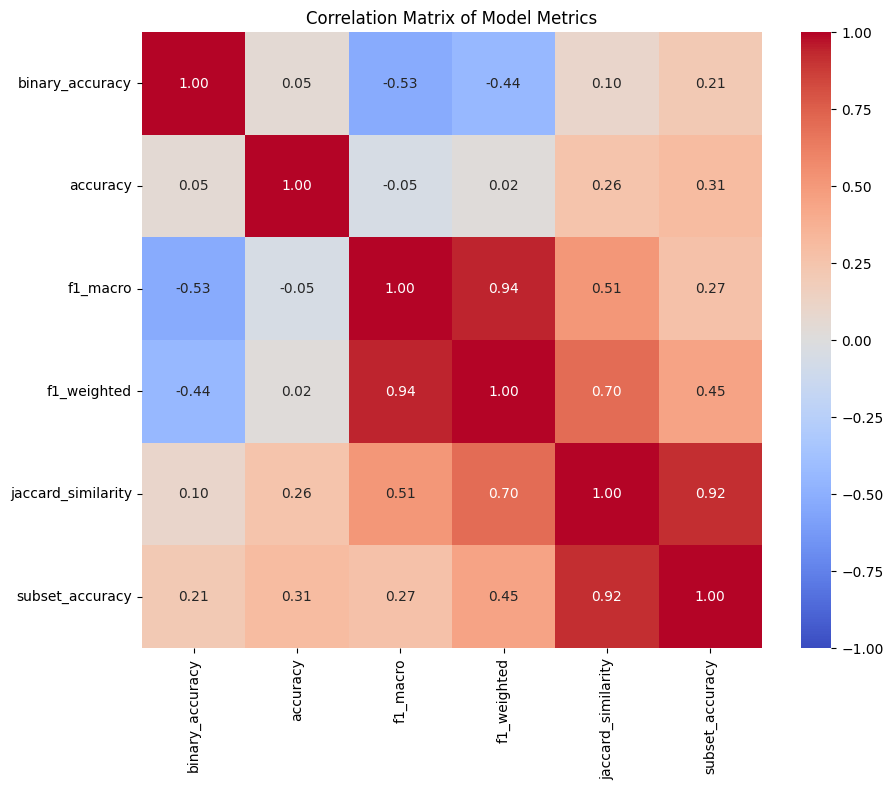

In [91]:
# calculate correlation
correlation_matrix = df_metrics[['binary_accuracy', 'accuracy', 'f1_macro', 'f1_weighted', 'jaccard_similarity', 'subset_accuracy']].corr()

# plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Model Metrics')
plt.show()